# Installing the oracle environment (Executed Once)

In [1]:
!pip install cx_Oracle

# Importing the oracle environment

In [1]:
import cx_Oracle
import os
directory_path = "PATH\instantclient-basic-windows.x64-21.3.0.0.0\instantclient_21_3"
cx_Oracle.init_oracle_client(lib_dir= directory_path)

In [2]:
my_username = "USERNAME"
my_password = "PASSWORD"

connection = cx_Oracle.connect(user=my_username, password=my_password, dsn="DOMAIN")

# Python Imports

In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import sklearn

# Establishing a cursor connection

In [4]:
with connection.cursor() as cursor:
    sql = cursor.execute("select l.location_id, t.dates,t.weekofyear, w.sensor_output from sensors s,locations l, water_quality w, time t where t.time_id = w.time_id and l.location_id = w.location_id and w.sensor_id=s.sensor_id and s.sensor_id = 117")
    data = df(sql.fetchall())
    data.columns = [x[0] for x in sql.description]

In [5]:
data

,LOCATION_ID,DATES,WEEKOFYEAR,SENSOR_OUTPUT
0,AN-02M06,23-11-2016,47,11.90
1,AN-02M04,07-12-2016,49,11.20
2,AN-02M06,25-01-2016,4,13.70
3,AN-01M14,14-03-2016,11,8.98
4,AN-01M07,09-05-2016,19,7.32
...,...,...,...,...
1116,AN-04M06,28-11-2016,48,9.27
1117,AN-04M08,22-08-2016,34,5.56
1118,AN-04M13,27-10-2016,43,5.84
1119,AN-04M19,27-06-2016,26,5.09


# Preprocessing

In [6]:
Locations = data.iloc[:,0].values
Dates = data.iloc[:,1].values
WK = data.iloc[:,2]
Results = data.iloc[:,3].values

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
re = preprocessing.LabelEncoder()

label = re.fit_transform(Results)
Locations_encoded=le.fit_transform(Locations)

In [8]:
season = ['']*1121
for i in range (0,1121):
    if Dates[i][3:5] <= '02':
         season[i] = 'Winter'
    elif Dates[i][3:5] <= '05':
        season[i] = 'Spring'
    elif Dates[i][3:5] <= '07':
        season[i] = 'Summer'
    elif Dates[i][3:5] <= '11':
        season[i]='Fall'
    else: season[i] = 'Winter'

In [9]:
we = preprocessing.LabelEncoder()
S = we.fit_transform(season)

In [10]:
MLDF = df({
    'Locations' : Locations_encoded,
    'Season'    : S,
    'Week of Year': WK,
    'Results'   : label,
    })


MLDF

,Locations,Season,Week of Year,Results
0,10,0,47,566
1,9,3,49,559
2,10,3,4,583
3,5,1,11,487
4,3,1,19,377
...,...,...,...,...
1116,26,0,48,505
1117,27,0,34,259
1118,29,0,43,276
1119,32,2,26,234


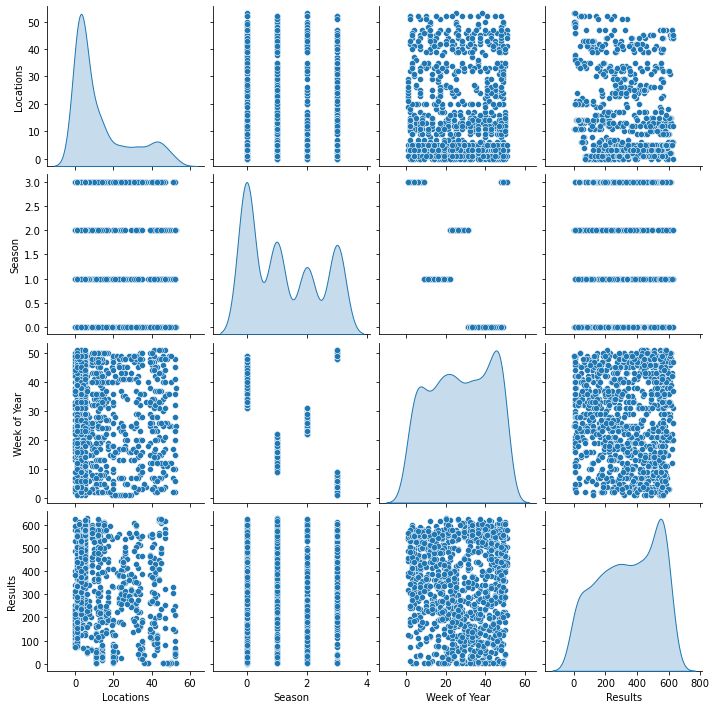

In [11]:
import seaborn as sns
sns.pairplot(data=MLDF, diag_kind='kde')
#The data is obviously imbalanced towards one or more locations more than the others
#Slight Skew in the results as well
#Dates are well distributed

C:\Institutions\Gre\Apps\Anaconda3-2021.05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


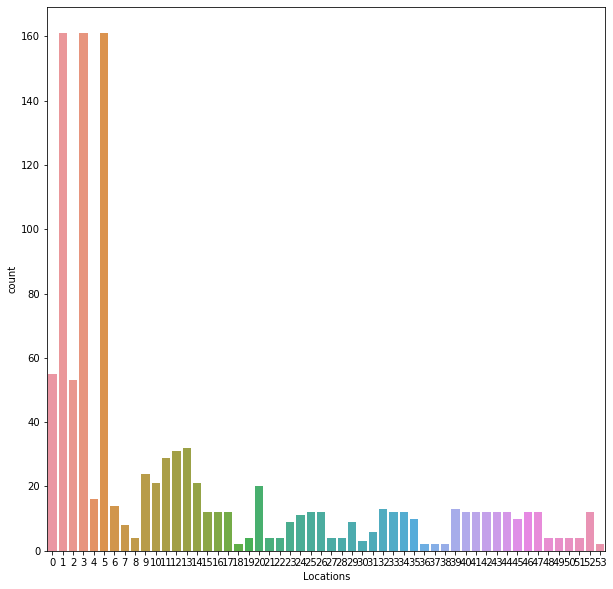

In [12]:
plt.figure(figsize=(10, 10)) #Set the figure size
g = sns.countplot(MLDF['Locations'])
plt.show()

C:\Institutions\Gre\Apps\Anaconda3-2021.05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


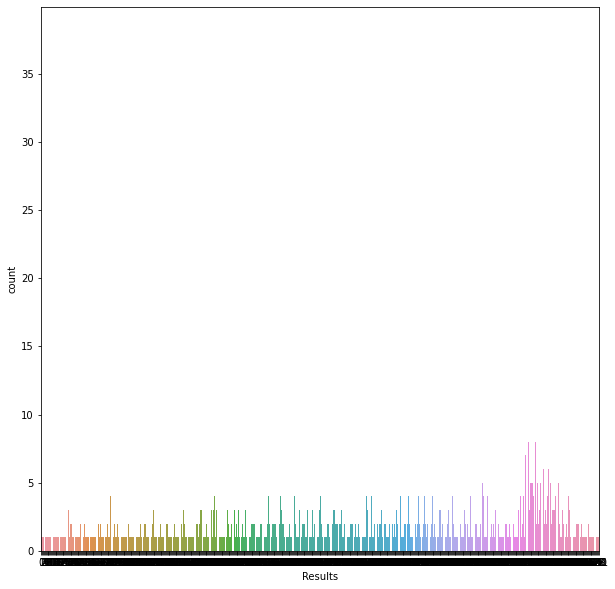

In [13]:
plt.figure(figsize=(10, 10)) #Set the figure size
g = sns.countplot(MLDF['Results'])
plt.show()

In [14]:
BMLDF = MLDF.drop(MLDF[MLDF.Locations == 0].index)
BMLDF = BMLDF.drop(BMLDF[BMLDF.Locations == 1].index)
BMLDF = BMLDF.drop(BMLDF[BMLDF.Locations == 2].index)
BMLDF = BMLDF.drop(BMLDF[BMLDF.Locations == 3].index)
BMLDF = BMLDF.drop(BMLDF[BMLDF.Locations == 5].index)

In [15]:
BMLDF

,Locations,Season,Week of Year,Results
0,10,0,47,566
1,9,3,49,559
2,10,3,4,583
6,50,2,25,4
7,42,0,48,359
...,...,...,...,...
1116,26,0,48,505
1117,27,0,34,259
1118,29,0,43,276
1119,32,2,26,234


In [16]:
X = BMLDF.iloc[:,:3]
Y = BMLDF.iloc[:,3]

C:\Institutions\Gre\Apps\Anaconda3-2021.05\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


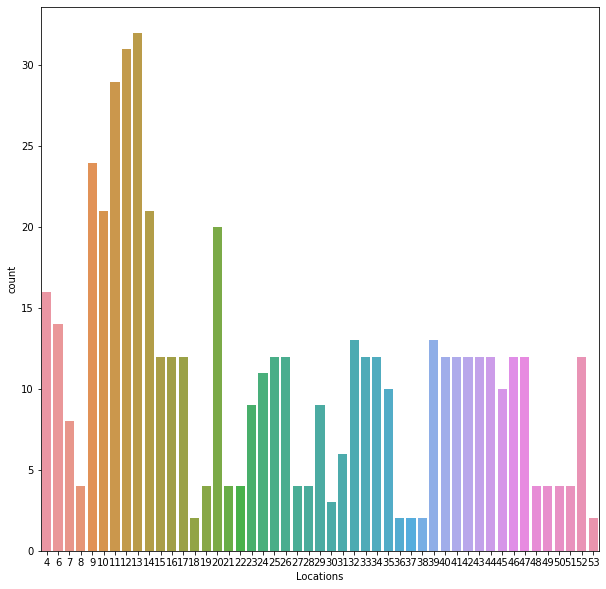

In [17]:
plt.figure(figsize=(10, 10)) #Set the figure size
g = sns.countplot(BMLDF['Locations'])
plt.show()

# Correlation

In [18]:
BMLDF.corr(method='kendall')

,Locations,Season,Week of Year,Results
Locations,1.000000,-0.009720,0.000988,-0.138742
Season,-0.009720,1.000000,-0.468833,0.077484
Week of Year,0.000988,-0.468833,1.000000,-0.025735
Results,-0.138742,0.077484,-0.025735,1.000000


# ML Methods

# KNN

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3, random_state=19)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [52]:
print('Accuracy is', round(knn.score(X_test, y_test),4)*100,'%')

Accuracy is 10.059999999999999 %


## Cross-Validation

In [26]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, Y)

C:\Institutions\Gre\Apps\Anaconda3-2021.05\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=19),
             param_grid={'n_neighbors': array([20, 21, 22, 23, 24])})

In [27]:
print(knn_gscv.best_params_)
print(knn_gscv.best_score_)

{'n_neighbors': 22}
0.062264150943396226
